In [1]:
import numba as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
N = 2 #10 lub 2
L = 100 #nm
mass = 0.067 #au
omega = 10.0 #meV
au_energy = 27211.6
ab = 0.05292 #nm to Bohr radius

n_els = (2*N)**2 #liczba elementów
n_glob = (2*N+1)**2 #liczba węzłów

x_nlg = np.concatenate([np.linspace(-L/2,L/2,2*N+1) for i in range(2*N+1)])
y_nlg = np.repeat(np.linspace(-L/2,L/2,2*N+1),2*N+1)
nlg = np.empty((n_els,4), dtype = int) #dla każdego elementu 4 węzły
#mesh = np.empty((2*N+1, 2*N+1))     #[i, j] = [y, x]
for k in range(n_els): #pętla po elementach
    for i in range(2): 
        nlg[k,i] = k + i + k//(2*N) #dla wezla 1 i 2
        nlg[k,i+2] = nlg[k,i] + 2*N+1 #dla wezla 3 i 4

In [3]:
df =pd.DataFrame(index = range(4*n_els),columns = ['Nr elementu', 'Nr lokalny węzła', 'Nr globalny węzła', 'x węzła', 'y węzła'])
for k in range(n_els):
    for i in range(4):
        df.iloc[4*k+i] = [k,i,nlg[k,i],x_nlg[nlg[k,i]],y_nlg[nlg[k,i]]]
df

,Nr elementu,Nr lokalny węzła,Nr globalny węzła,x węzła,y węzła
0,0,0,0,-50.0,-50.0
1,0,1,1,-25.0,-50.0
2,0,2,5,-50.0,-25.0
3,0,3,6,-25.0,-25.0
4,1,0,1,-25.0,-50.0
...,...,...,...,...,...
59,14,3,23,25.0,50.0
60,15,0,18,25.0,25.0
61,15,1,19,50.0,25.0
62,15,2,23,25.0,50.0


In [4]:
def f(i,ksi):
    if i == 0:
        return (1-ksi)/2;
    elif i == 1:
        return (1+ksi)/2;
    else:
        print('[ERROR] Unrecognized function')
        exit(-1)
def g(i,ksi_vec):
    if i == 0:
        return f(0,ksi_vec[0])*f(0,ksi_vec[1])
    elif i == 1:
        return f(1,ksi_vec[0])*f(0,ksi_vec[1]) 
    elif i == 2:
        return f(0,ksi_vec[0])*f(1,ksi_vec[1])
    elif i == 3:
        return f(1,ksi_vec[0])*f(1,ksi_vec[1])
    else:
        print('[ERROR] Unrecognized function')
        exit(-1)
        
Psi_nlg = np.empty(n_glob)
for n in range(n_glob): Psi_nlg[n] = np.exp(-mass*omega/au_energy/2.*((x_nlg[n]/ab)**2+(y_nlg[n]/ab)**2))
ksi_step = 0.1
ksi0_tab = np.arange(-1,1 + ksi_step,ksi_step)
ksi1_tab = np.arange(-1,1 + ksi_step,ksi_step)


x = np.empty((n_els, np.size(ksi0_tab)))  
y = np.empty((n_els, np.size(ksi1_tab)))  
Psi = np.zeros((n_els, np.size(ksi1_tab), np.size(ksi0_tab)))   

for k in range(n_els):
    for m in range (np.size(ksi0_tab)):
        for n in range(np.size(ksi1_tab)):
            x[k,m] = x_nlg[nlg[k,0]]/2*(1-ksi0_tab[m]) + x_nlg[nlg[k,1]]/2*(1+ksi0_tab[m])
            y[k,n] = y_nlg[nlg[k,0]]/2*(1-ksi1_tab[n]) + y_nlg[nlg[k,2]]/2*(1+ksi1_tab[n])
            for i in range(4):
                Psi[k,n,m] += Psi_nlg[nlg[k,i]]*g(i,[ksi0_tab[m], ksi1_tab[n]])  
           
for i in range(2*N):
    Psi_new = np.concatenate(Psi[i*2*N:(1+i)*2*N], axis = 1)
    if i == 0:
        Psi_r = Psi_new
    else:
        Psi_r = np.concatenate((Psi_r, Psi_new), axis = 0)
        
Psi_r = np.delete(Psi_r, [np.size(ksi0_tab)*i for i in range(1,2*N)], axis = 1)
Psi_r = np.delete(Psi_r, [np.size(ksi1_tab)*i for i in range(1,2*N)], axis = 0)

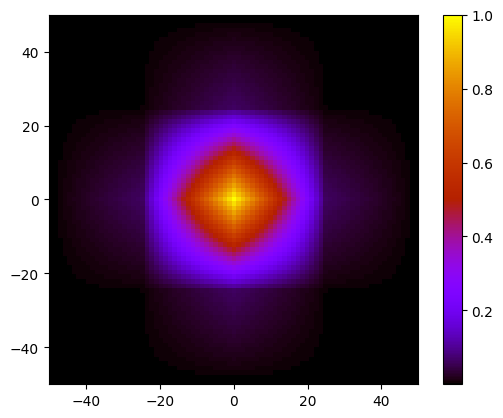

In [5]:
plt.imshow(Psi_r, origin='lower', cmap='gnuplot', extent=[-50,50,-50,50], interpolation=None)
plt.colorbar()

# Zadanie 3
 Policzyć i wypisać elementy lokalnej macierzy przekrywania

In [6]:
#trójpunktowa kwadratura gaussa
L=100/ab #w jednostkach atomowych
N=2
a=L/N #w jednostkach atomowych
p = np.array([-math.sqrt(3/5),0,math.sqrt(3/5)])
w = np.array([5/9,8/9,5/9])

#lokalna macierz przekrywania
s = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        for l in range(3):
            for n in range(3):
                s[i,j] += (a**2)/4*(w[l]*w[n]*g(j,[p[l], p[n]])*g(i,[p[l], p[n]]))
print('s:\n',s)   
print('s do porownania ze skryptem:')
s2=s/((a**2)/4)*9
print(s2)

s:
 [[99187.70191839 49593.85095919 49593.85095919 24796.9254796 ]
 [49593.85095919 99187.70191839 24796.9254796  49593.85095919]
 [49593.85095919 24796.9254796  99187.70191839 49593.85095919]
 [24796.9254796  49593.85095919 49593.85095919 99187.70191839]]
s do porownania ze skryptem:
[[4. 2. 2. 1.]
 [2. 4. 1. 2.]
 [2. 1. 4. 2.]
 [1. 2. 2. 4.]]


# Zadanie 4
Policzyć i wypisać elementy lokalnej macierzy przekrywania

In [9]:
delta=0.01
def der1(ii,pl,pn):
    return((g(ii,[pl,pn+delta])-g(ii,[pl,pn-delta]))/(2*delta))
def der2(ii,pl,pn):
    return((g(ii,[pl+delta,pn])-g(ii,[pl-delta,pn]))/(2*delta))

t = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        for l in range(3):
            for n in range(3):
                t[i,j] += (1/(2*mass))*(w[l]*w[n]*(der1(j,p[l],p[n])\
                                      *der1(i,p[l],p[n])+der2(j,p[l],p[n])*der2(i,p[l],p[n])))
print('t:\n',t) 
t2=t*6*2*mass
print('t do porownania ze skryptem:\n',t2)       

t:
 [[ 4.97512438 -1.24378109 -1.24378109 -2.48756219]
 [-1.24378109  4.97512438 -2.48756219 -1.24378109]
 [-1.24378109 -2.48756219  4.97512438 -1.24378109]
 [-2.48756219 -1.24378109 -1.24378109  4.97512438]]
t do porownania ze skryptem:
 [[ 4. -1. -1. -2.]
 [-1.  4. -2. -1.]
 [-1. -2.  4. -1.]
 [-2. -1. -1.  4.]]


In [76]:

#lokalne macierze przekrywania dla energii potencjalnej są różne dla każdego elementu
v = np.zeros((n_els,4,4))
omega=10/au_energy

for k in range(n_els):
    for i in range(4):
        for j in range(4):
            calka=0
            for l in range(3):
                for n in range(3):
                    xc=(x_nlg[nlg[k,0]]/ab*(1-p[n])+x_nlg[nlg[k,1]]/ab*(1+p[n]))/2
                    yc=(y_nlg[nlg[k,0]]/ab*(1-p[l])+y_nlg[nlg[k,2]]/ab*(1+p[l]))/2
                    calka=calka+(((xc)**2+(yc)**2)*g(j,[p[l], p[n]])*g(i,[p[l], p[n]]))*w[l]*w[n]
            v[k,i,j]=calka*((a**2)/4)*mass*(omega**2)/2

#sprawdzenie dla wezla 11            
k=10
for i in range(4):
    print(x_nlg[nlg[k,i]],y_nlg[nlg[k,i]],(v[k,i,i]/s[i,i])*au_energy) #wspolrzedne wezla

0.0 0.0 5.494916162297354
25.0 0.0 19.232206568040752
0.0 25.0 19.23220656804075
25.0 25.0 32.969496973784146
